# SUPERSTORE PROJECT
by: Kristofer Rivera, Oliver Ton - 04/21/2022

## Overview

Superstore's mission is to be the preferred supplier of workspace solutions; from home-office to cooperate office, we aspire to be the leading expert in workplace solutions for everyone! For this reason, it is important to know whether we are reaching everyone with our products and services. This project will use exploration, modeling to identify the best category for Superstore in regards to sales and will provide recommendations on where to shift our company focus in order to maintain happy loyal customers while continuing to grow our customer base.

## Goal

The goal of this project is to identify which category is the best for SuperStore, a office-supply retail store, and make recommendations on where to shift company focus in regards to category.



## Focused Questions

1.What category base contributes the most to profit?

2.What category base contributes the most to sales?

3.How does the impact of each customer segment change over time?

4.What is the future sales and profit goals look like over time?

In [1]:
# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# for tsa
import statsmodels.api as sm

#important import 
import pandas as pd
import numpy as np
import os
import wrangle as w
import model as m

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

Importing plotly failed. Interactive plots will not work.


---

### Wrangle

The data was acquired by accessing *superstore_db* from Codeup database. The query was used to acquire the superstore dataset, check the wrangle.py for more information. After data acquisition, the table was analyzed, cleaned, rename columns, clarify confusion and standardize datatypes. All the preparation can found in wrangle.py (https://github.com/Kristofer-Rivera-and-Oliver-Ton/time_series_project/blob/main/wrangle.py).

---

In [2]:
#Acquire superstore dataset
df = w.get_superstore_data()

In [3]:
#Clean superstore data
df = w.prep_superstore(df, 'Order Date', 'Ship Date')

In [4]:
#Split our data 
train, validate, test = w.split_time_series_data(df)

**Take away:**
- The data have no nulls, change datatypes of order date and ship date into datetime and then set order date as an index.
- Remove id columns (foreign keys)
- Rename columns, create month columns (month name)
- Split data into train, validate and test

---

### Exploration
Focused Questions
- What category base contributes the most to profit?
- What category base contributes the most to sales?
- How does the impact of each customer segment change over time?
- What is the future sales and profit goals look like over time?

---

#### We started with an overview of Sales Volume per year and Average Sales per Month

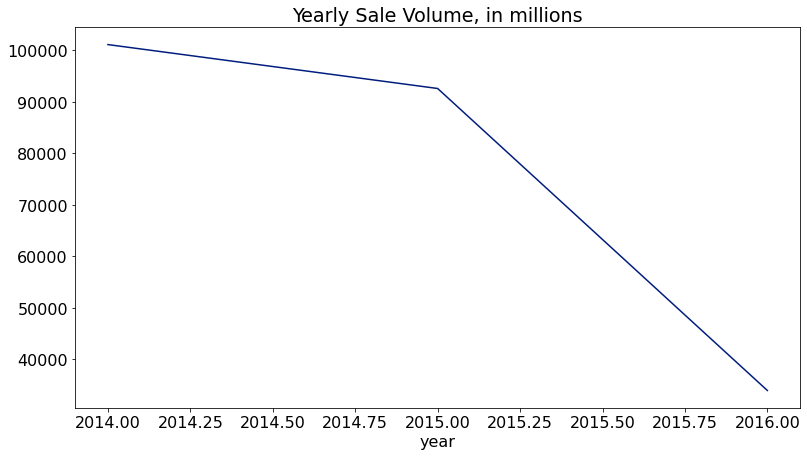

In [5]:
train['year'] = train.index.year
train.groupby('year').sales.sum().plot()
plt.title('Yearly Sale Volume, in millions')
plt.show()

**There has been a steady drop in overall sales since 2015.**

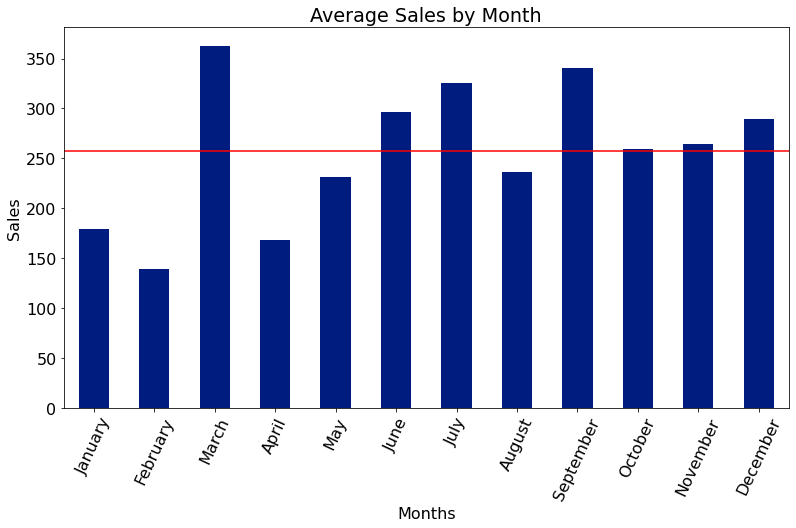

In [6]:
#What our average sales look like for each month?
train['month'] = pd.Categorical(train['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
overall_mean = train.groupby('month').sales.mean().mean()
train.groupby('month').sales.mean().plot.bar()
plt.title("Average Sales by Month")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.tick_params('x', rotation=65)
plt.axhline(overall_mean,color="r")
None

<AxesSubplot:title={'center':'Seasonal Plot of Sales'}, xlabel='Order Date'>

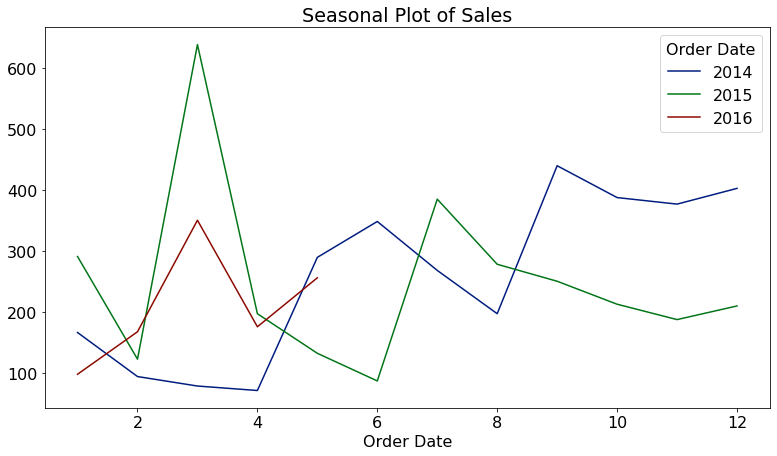

In [7]:
y = train.sales
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot of Sales')

**We see a spike in overall sales in March, higher than average sales in the summer months and at the end of the year, as well as another spike in September.**

### Our exploration was guided by the following questions: 
#### - Is there a product category that is particularly profitable for us? 

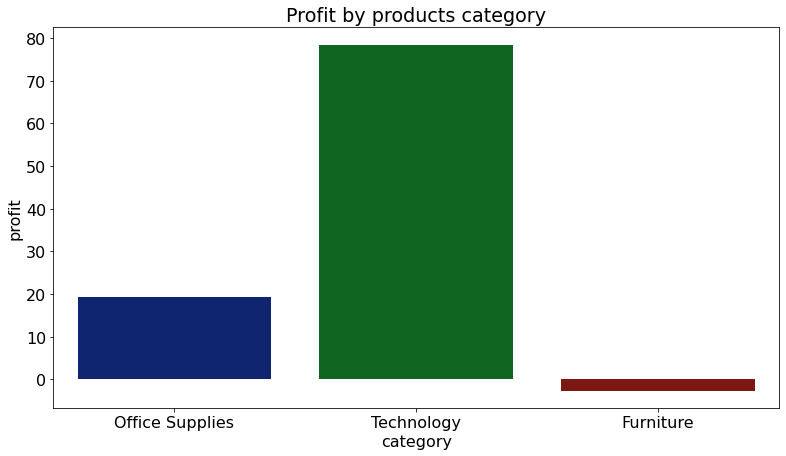

In [8]:
sns.barplot(x='category', y='profit', data= train, ci=None)
plt.title('Profit by products category')
None

**Takeaway: Technology is by far the most profitable product category.**

#### - Does one or another category stand out in terms of sales volume?

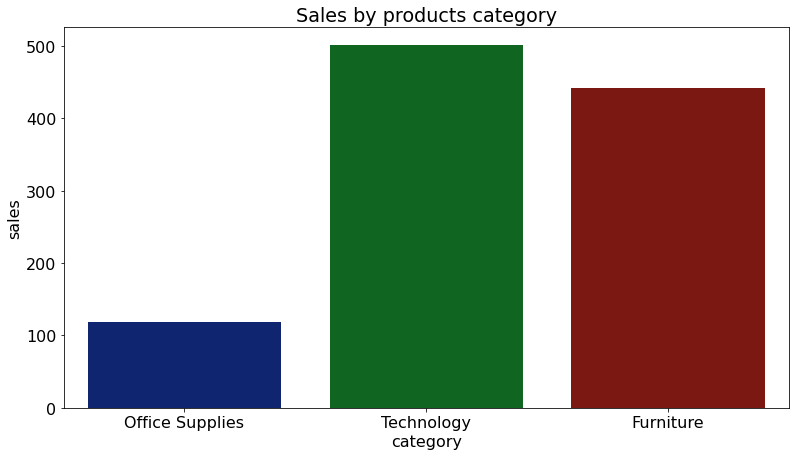

In [9]:
sns.barplot(x='category', y='sales', data= train, ci=None)
plt.title('Sales by products category')
None

**Takeway: Technology also leads in sale volume but furniture is a close second.**

#### Next we decided to visualize the Sales Volume by Product Categories Over Time

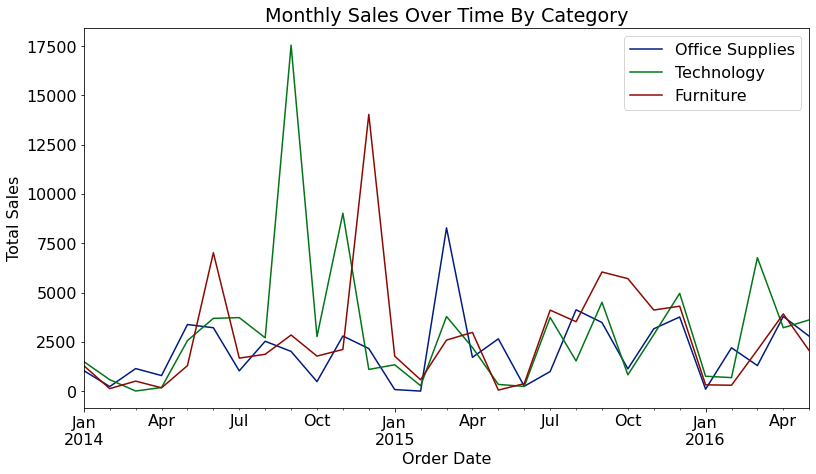

In [23]:
#Better graph
for c in train.category.unique():
    sample = train[train.category == c]
    sample.resample('M').sales.sum().plot(label=c)
    plt.legend()
plt.title("Monthly Sales Over Time By Category")
plt.ylabel("Total Sales")
None

**Takeway: Most of our technology sales are occuring around August and September. We also see a large spike in furniture sales at the end of the year.**

#### - Does the profitability and sales volumne of the product categories vary by customer segment?

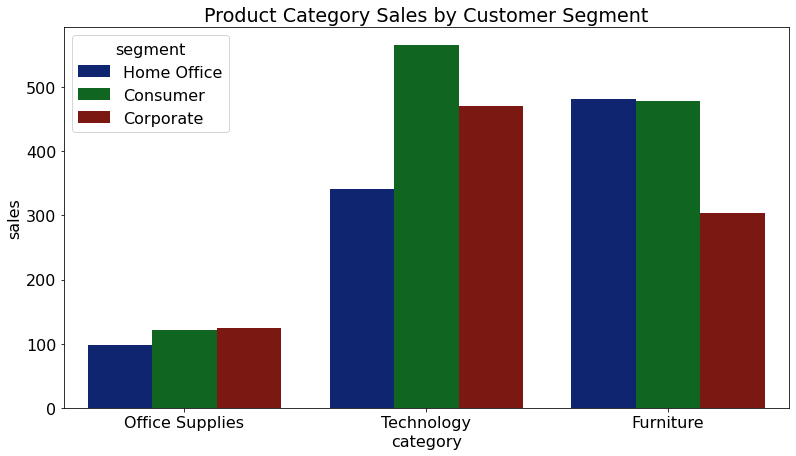

In [11]:
sns.barplot(x='category', y='sales', data= train, hue='segment', ci=None)
plt.title('Product Category Sales by Customer Segment')
None

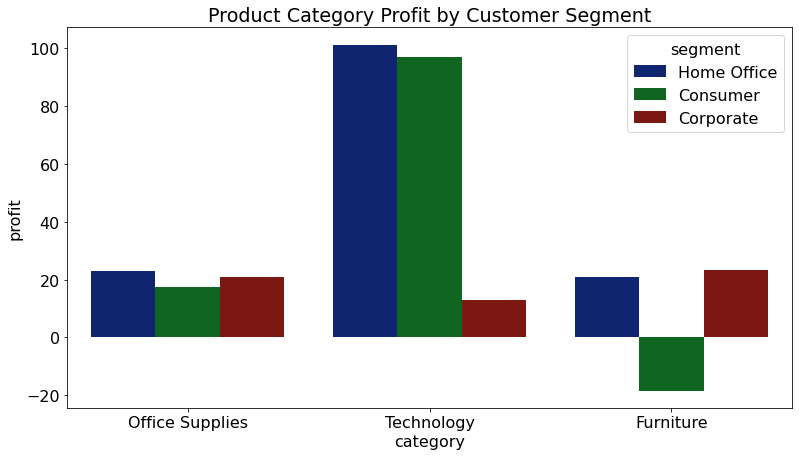

In [12]:
# Let's visualize the same thing using profit instead of sales
sns.barplot(x='category', y='profit', data= train, hue='segment', ci=None)
plt.title('Product Category Profit by Customer Segment')
None

**Takeways: The consumer and home office customer segments are the most profitable segments. While corporate customers make up a large portion of our sales volume they are the least profitable customers.**

### We established technology as the most profitable product category and decided to dive deeper into its subcategories.

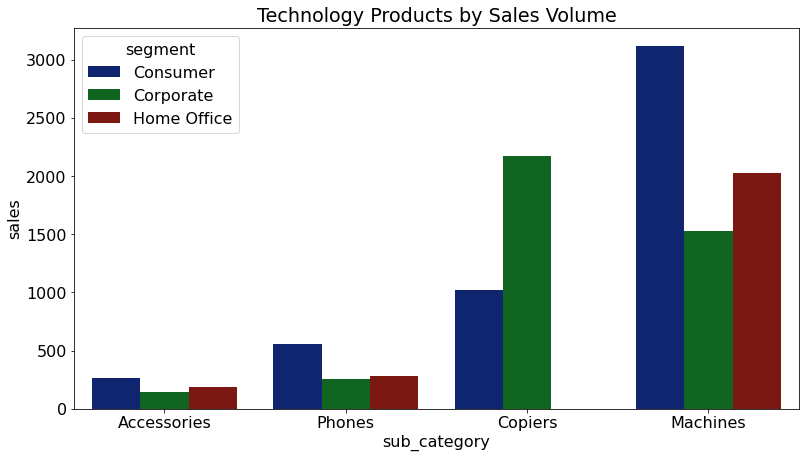

In [13]:
# Create a dateframe including only technology products
technology = train.loc[train['category'] == 'Technology']
sns.barplot(x='sub_category', y='sales', data= technology, hue='segment', ci=None)
plt.title('Technology Products by Sales Volume')
None

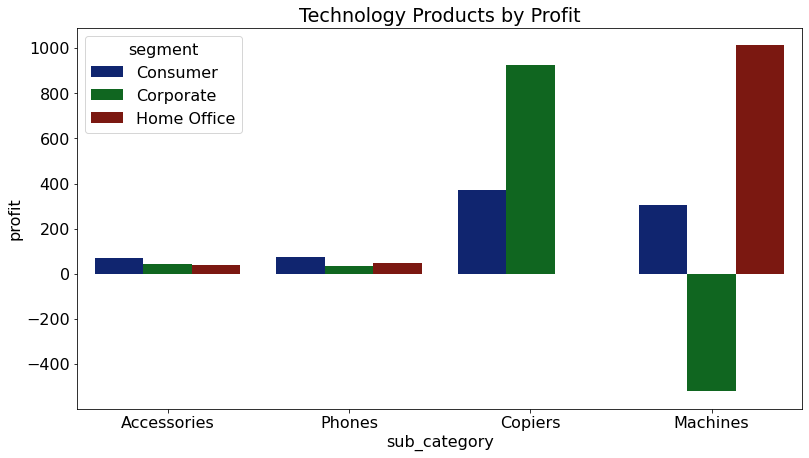

In [14]:
sns.barplot(x='sub_category', y='profit', data= technology, hue='segment', ci=None)
plt.title('Technology Products by Profit')
None

**Takeways:**
- Copiers and machines make up the bulk of both sale volume and profit. 
- While machines are very profitable for home office customers, we lost money selling machines to corporate customers. 

#### We wanted to look at sales by decomposing our time series into trend, seasonal, and noise components.

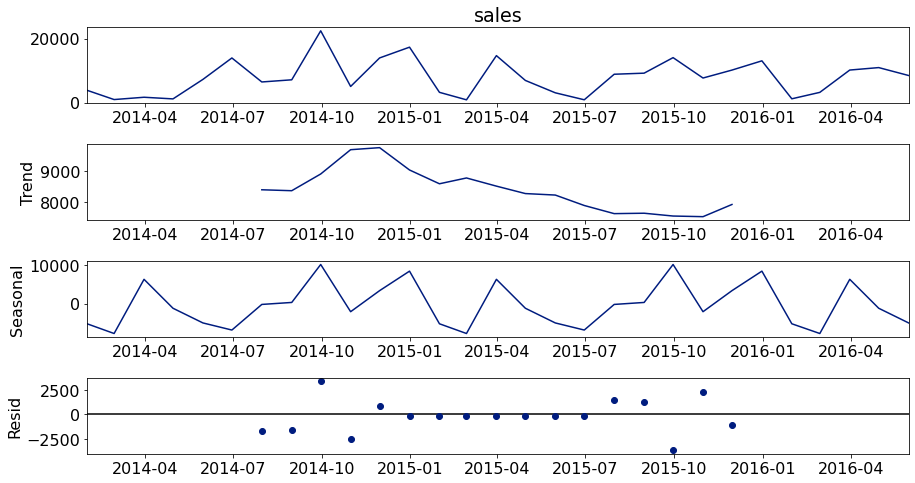

In [15]:
# Using decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
y = train.resample('M').sales.sum()
sm.tsa.seasonal_decompose(y).plot()
None

**Takeways: We sell the vast majority of machines between Frebuary and October with a steep drop off in October.**

---

## Modeling

We will working with *prophet* for model because Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. Please check model.py for more detail (https://github.com/Kristofer-Rivera-and-Oliver-Ton/time_series_project/blob/main/model.py)

---

In [20]:
#Create model
technology_sales_model, technology_sales_forecast, technology_profit_forecast, technology_profit_model = m.create_model(train, 'category', 'Order Date', 'sales', 'profit')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -48.4645
Iteration  1. Log joint probability =    23.0903. Improved by 71.5548.
Iteration  2. Log joint probability =    23.6263. Improved by 0.535956.
Iteration  3. Log joint probability =    32.8536. Improved by 9.22733.
Iteration  4. Log joint probability =    39.4221. Improved by 6.56851.
Iteration  5. Log joint probability =    47.6214. Improved by 8.1993.
Iteration  6. Log joint probability =    47.9896. Improved by 0.368131.
Iteration  7. Log joint probability =    47.9978. Improved by 0.00827731.
Iteration  8. Log joint probability =    48.0222. Improved by 0.0243931.
Iteration  9. Log joint probability =    48.1383. Improved by 0.116118.
Iteration 10. Log joint probability =    48.1536. Improved by 0.0152914.
Iteration 11. Log joint probability =    48.1605. Improved by 0.00685912.
Iteration 12. Log joint probability =    48.1827. Improved by 0.0222345.
Iteration 13. Log joint probability =     48.215. Improved by 0.0323123.
Iteration 14. Log j

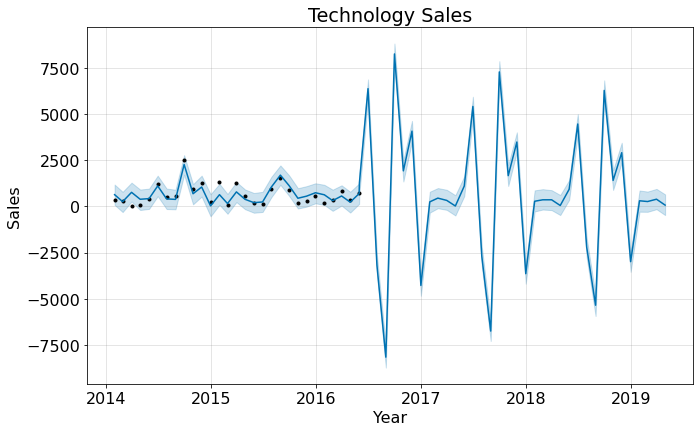

In [21]:
#Forecasting future sales for technologies
technology_sales_model.plot(technology_sales_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Technology Sales')
plt.show()

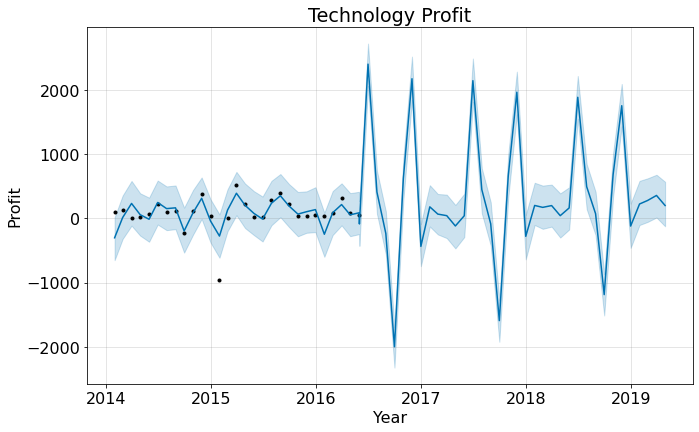

In [22]:
#Forecasting future profit for technologies
technology_profit_model.plot(technology_profit_forecast, xlabel = 'Year', ylabel = 'Profit')
plt.title('Technology Profit')
plt.show()

**Take away:**
As you can see, if we take the recommendations,  our sales and profit are increase over time and continue to grow.

---

### Conclusion

### Recomendations

### Next steps